<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Hard Negative Sampling for Image Classification

Hard negative sampling is ...  `<brief explanation>`


Training workflow is as follows:
1. Prepare training set *T* and unlabeled set <i>U</i>
2. Load a pre-trained ImageNet model
3. Train the model on *T*
4. Score the model on *U* 
5. Identify *n* (=100) hard images in <i>U</i>, annotate and add to <i>T</i>
  * Hard images could be:
    - Samples mis-classified with high-confidence
    - Samples correctly predicted with low-confidence
6. Repeat step 3-5 if needed

Let's get started. First few cells are pretty much the same as [01_training_introduction notebook](./01_training_introduction.ipynb).

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [45]:
import sys
sys.path.append("../../")
from functools import partial 

import numpy as np
from pathlib import Path

# fastai and torch
import fastai
from fastai.vision import (
    models, untar_data, URLs, get_image_files, ImageList, imagenet_stats, cnn_learner, DatasetType,
    ClassificationInterpretation,
)
from fastai.metrics import accuracy

# local modules
from utils_cv.classification.model import (
    IMAGENET_IM_SIZE as IMAGE_SIZE,
    TrainMetricsRecorder
)
from utils_cv.classification.plot import plot_pr_roc_curves
from utils_cv.classification.widget import ResultsWidget
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.common.image import show_im_files
from utils_cv.common.misc import set_random_seed

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla P40
Available / Total memory = 21588 / 22919 (MiB)


In [3]:
EPOCHS        = 5
LEARNING_RATE = 1e-4
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50
SEED          = 10

## 1. Prepare datasets

To demonstrate the hard negative sampling usecase, we introduce one more class to our fridge obejct classification problem: the class 'pets'.

So, our endgoal is to classify an image into one of following classes: watter bottle, carton, can, milk bottle, and **pets**.

* The initial training set *T* will include fridge objects and **very few** pets images.
* Unlabeled set *U* will include only pets. We will see how our model work on this data set.
* Validation set *V* will have both fridge objects and pets.

In [4]:
fridge_datapath = Path(unzip_url(Urls.fridge_objects_path, exist_ok=True))
pet_datapath = Path(untar_data(URLs.PETS))/'images'

/data/anaconda/envs/cvbp/lib/python3.6/site-packages/fastai/datasets.py:159: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


Let's see example images

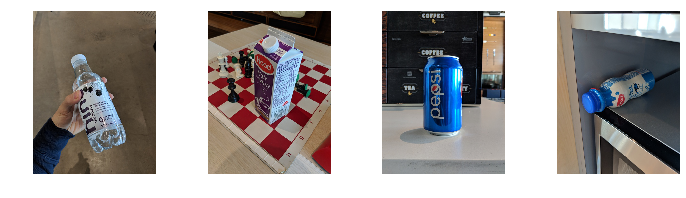

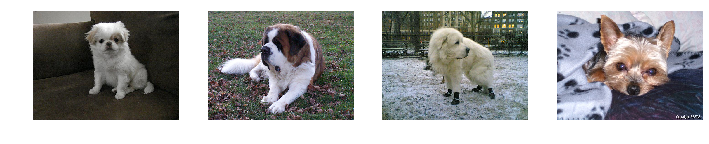

In [5]:
fridge_object_examples = [
    get_image_files(fridge_datapath/'water_bottle')[0],
    get_image_files(fridge_datapath/'carton')[0],
    get_image_files(fridge_datapath/'can')[0],
    get_image_files(fridge_datapath/'milk_bottle')[0],
]
pet_examples = get_image_files(pet_datapath)[:4]

show_im_files(fridge_object_examples)
show_im_files(pet_examples)

In [6]:
fridge_objects = (ImageList.from_folder(fridge_datapath)
                  .split_by_rand_pct(valid_pct=0.2, seed=SEED)
                  .label_from_folder())
pets = (ImageList.from_folder(pet_datapath)
        .split_by_rand_pct(valid_pct=0.2, seed=SEED))

In [54]:
import os
import shutil
from tempfile import TemporaryDirectory
tmpdir = TemporaryDirectory()
data_path = Path(tmpdir.name)/'data'


def copy_files(files, dst):
    os.makedirs(dst, exist_ok=True)
    for f in files:
        shutil.copy(f, dst)

# Training set
copy_files(fridge_objects.train.items, data_path/'train')
copy_files(pets.train.items[:10], data_path/'train')  # add 10 pet images to our initial training set.

# Validation set
copy_files(fridge_objects.valid.items, data_path/'valid')
copy_files(pets.valid.items, data_path/'valid')

# Test set (unlabeled data. We know this is pet data, but let's pretend we don't know for now)
copy_files(pets.train.items[10:], data_path/'test')

In [61]:
y_dict = {
    os.path.basename(n): str(fridge_objects.train.y[i]) for i, n in enumerate(fridge_objects.train.items)
}
y_dict.update({
    os.path.basename(n): str(fridge_objects.valid.y[i]) for i, n in enumerate(fridge_objects.valid.items)
})

def get_y_fn(x):
    x = os.path.basename(x)
    return y_dict.get(x) if x in y_dict else 'pet'

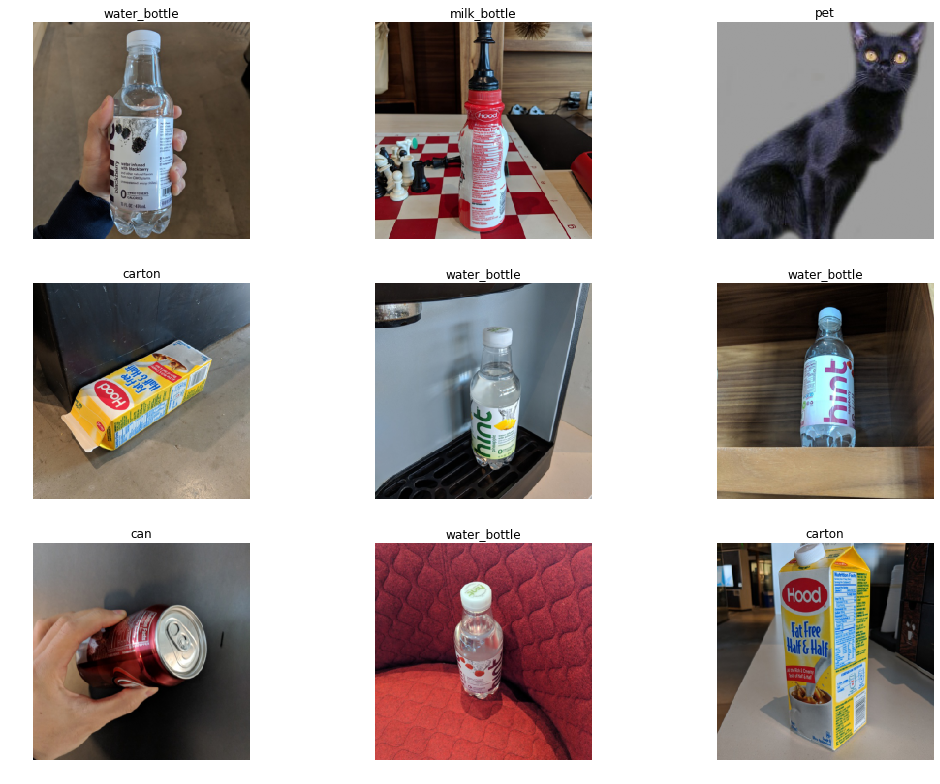

In [66]:
set_random_seed(SEED)
data = (ImageList.from_folder(data_path)
        .split_by_folder()
        .label_from_func(get_y_fn)
        .add_test_folder()
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))
data.show_batch(rows=3, figsize=(15,11))

In [67]:
print(f'number of classes: {data.c} = {data.classes}')
print(data.batch_stats)

number of classes: 5 = ['can', 'carton', 'milk_bottle', 'pet', 'water_bottle']
<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (118 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
milk_bottle,water_bottle,pet,can,can
Path: /tmp/tmpboqsbvq4/data;

Valid: LabelList (1504 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pet,pet,pet,pet,pet
Path: /tmp/tmpboqsbvq4/data;

Test: LabelList (5902 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /tmp/tmpboqsbvq4/data>


> Note Test set doesn't have labels

## 2. Load a pre-trained ImageNet model

Same as 01_training_introduction notebook, we use [ResNet50](https://arxiv.org/abs/1512.03385) pre-trained on [ImageNet](http://www.image-net.org/). We use the custom callback `TrainMetricsRecorder` to track the accuracy on the training set during training same as the previous notebook.

In [76]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

## 3. Train the model on *T*

In [77]:
# We are training all the layers
learn.unfreeze()

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.731133,1.154743,0.366071,0.655585,00:05
1,1.081710,1.015080,0.875000,0.763963,00:05
2,0.747771,0.663903,0.964286,0.920213,00:05
3,0.550505,0.425071,1.000000,0.964761,00:05
4,0.430382,0.307762,0.982143,0.978059,00:05


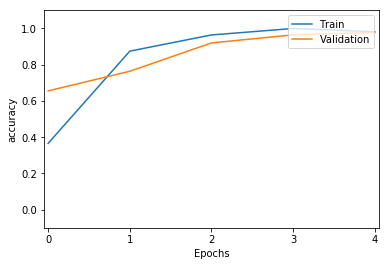

In [78]:
learn.fit(EPOCHS, LEARNING_RATE)

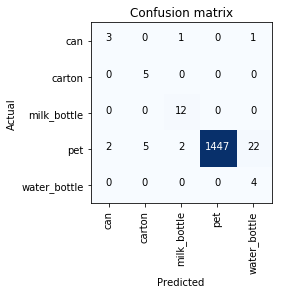

In [83]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## 4. Score the model on *U* 

In [79]:
pred = learn.get_preds(DatasetType.Test)
pred = pred[1].tolist()

In [80]:
pred_labels = [data.classes[c] for c in pred]
pred_labels[:10]

['can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can', 'can']

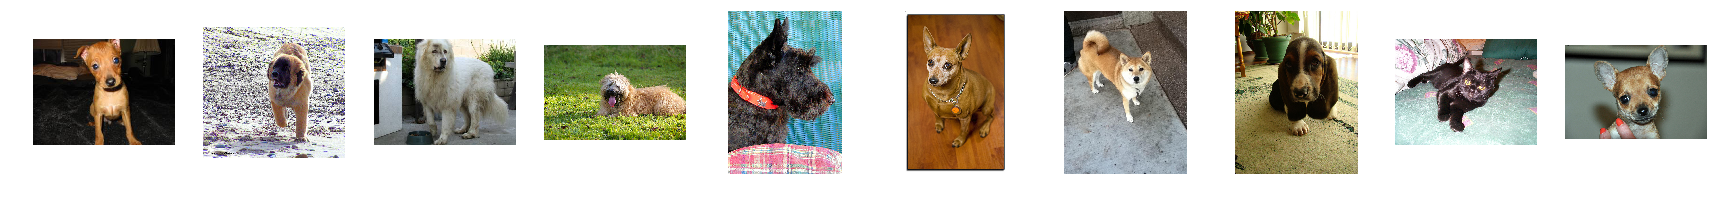

In [81]:
show_im_files(data.test_ds.items[:10])

Unfreeze our CNN since we're training all the layers.

## 5. Hard negative sampling

In [ ]:
# TODO move 10 images to train

In [ ]:
# TODO retrain the model

Now, analyze the classification results by using `ClassificationInterpretation` module.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
# Get prediction scores. We convert tensors to numpy array to plot them later.
pred_scores = to_np(interp.probs)

In [ ]:
w_results = ResultsWidget(
    dataset=learn.data.valid_ds,
    y_score=pred_scores,
    y_label=[data.classes[x] for x in np.argmax(pred_scores, axis=1)]
)
display(w_results.show())

We can plot precision-recall and ROC curves for each class as well. Please note that these plots are not too interesting here, since the dataset is easy and thus the accuracy is close to 100%.

In [ ]:
# True labels of the validation set. We convert to numpy array for plotting.
true_labels = to_np(interp.y_true)
plot_pr_roc_curves(true_labels, pred_scores, data.classes)

Let's take a close look how our model confused some of the samples (if any). The most common way to do that is to use a confusion matrix.

In [ ]:
interp.plot_confusion_matrix()

When evaluating our results, we want to see where the model messes up, and whether or not we can do better. So we're interested in seeing images where the model predicted the image incorrectly but with high confidence (images with the highest loss).

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

That's pretty much it! Now you can bring your own dataset and train your model on them easily. 